In [147]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, least_squares
from scipy.integrate import quad
import matplotlib.pyplot as plt
from importlib import reload
import OptionPricers
reload(OptionPricers)
from OptionPricers import Black76Call, Black76Put, SABR
import pickle
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Data required from previous parts

# 1. Discount Curve (OIS & LIBOR)
with open('data/ois_discount_curve.pkl', 'rb') as f:
    ois_discount_curve = pickle.load(f)
with open('data/libor_discount_curve.pkl', 'rb') as f:
    libor_discount_curve = pickle.load(f)

# 2. Calibrated SABR params
sabr_alpha_df = pd.read_excel("data/model_calibration.xlsx", sheet_name="sabr_alpha", index_col=0)
sabr_alpha_df.columns = sabr_alpha_df.columns.astype('int64')
sabr_rho_df = pd.read_excel("data/model_calibration.xlsx", sheet_name="sabr_rho", index_col=0)
sabr_rho_df.columns = sabr_rho_df.columns.astype('int64')
sabr_nu_df = pd.read_excel("data/model_calibration.xlsx", sheet_name="sabr_nu", index_col=0)
sabr_nu_df.columns = sabr_nu_df.columns.astype('int64')

# 3. Swap Rate Curve
def swap_pv01(Tn, N, freq):
    Do = ois_discount_curve
    TN = Tn + N
    dc = 1.0/freq # day count fraction
    return dc * (Do(np.arange(TN,Tn,-dc)).sum())

def swap_curve(Tn, N, freq):
    Do = ois_discount_curve
    D = libor_discount_curve
    TN = Tn + N
    PV01 = swap_pv01(Tn, N, freq)
    dc = 1.0/freq # day count fraction
    PV_flt = sum([Do(i)*(D(i-dc)-D(i))/D(i) if i>dc \
                  else Do(i)*(1-D(i))/D(i) \
                for i in np.arange(TN,Tn,-dc)])
    return PV_flt / PV01

A CMS contract paying the swap rate $S_{n,N}(T)$ at time $T=T_n$ can be expressed as
\begin{equation*}
\begin{split}
    \dfrac {V_0}{D(0,T)} = E^T[\dfrac {V_T}{D(T,T)}] = E^T[S_{n,N}(T)]
\end{split}
\end{equation*}

By static-replication approach, and choosing the forward swap rate $F=S_{n,N}(0)$ as the expansion
point, we can express $V_0$ as
\begin{equation*}
\begin{split}
    V_0 &= D(0,T) g(F) + h'(F)[V^{pay}(F)-V^{rec}(F)] \\
    &\;\;\;\;\;\;\;\;\;\;+ \int_0^F h''(K) V^{rec}(K) dK +
    \int_F^\infty h''(K) V^{pay}(K) dK \\
    &= D(0,T)g(F) + \int_0^F h''(K) V^{rec}(K) dK +
    \int_F^\infty h''(K) V^{pay}(K) dK
\end{split}
\end{equation*}

So, CMS rate can be written as
\begin{equation*}
\begin{split}
    E^T[S_{n,N}(T)] &= g(F) + \dfrac {1}{D(0,T)} [\int_0^F h''(K) V^{rec}(K) dK +
    \int_F^\infty h''(K) V^{pay}(K) dK]
\end{split}
\end{equation*}

Here, 

1) the IRR-settled option pricer $V^{pay}$ or $V^{rec}$
\begin{equation*}
\begin{split}
    V_0(K) &= D(0,T) \cdot IRR(S_{n,N}(0)) \cdot Black76(S_{n,N}(0), K, \sigma_{SABR}, T)
\end{split}
\end{equation*}

2) payoff function 
$$
    g(K)=K
$$

3) $h(K)$ and its partial derivatives
\begin{equation*}
\begin{split}
    h(K) &= \frac{g(K)}{IRR(K)}\\
    h'(K) &= \frac{IRR(K)g'(K) - g(K)IRR'(K)}{IRR(K)^2}\\
    h''(K) &= \frac{IRR(K)g''(K)-IRR''(K)g(K) -2\cdot IRR'(K)g'(K)}{IRR(K)^2} \\
    &\;\;\;\;\;\;\;\;\;\;+ \frac{2\cdot IRR'(K)^2g(K)}{IRR(K)^3}
\end{split}
\end{equation*}

4) a swap with tenor $N = T_N-T_n$ (years), the partial derivatives on $IRR(S)$ are
\begin{equation*}
\begin{split}
IRR(K)&=\sum_{i=1}^{N\times m}\frac{1}{(1+\frac{K}{m})^i}=\frac{1}{K}\left[1-\frac{1}{\left(1+\frac{K}{m}\right)^{N\times m}}\right]\\
IRR'(K)&=-\frac{1}{K}IRR(K)
+\frac{1}{m\times K}\frac{N\times m}{\left(1+\frac{K}{m}\right)^{N\times m+1}} \\
IRR''(K)&=-\frac{2}{K}IRR'(K)
-\frac{1}{m^2\times K}\frac{N\times m\cdot (N\times m+1)}{\left(1+\frac{K}{m}\right)^{N\times m+2}} \\
\end{split}
\end{equation*}


In [267]:
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    return 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    # return sum([1/m / (1+K/m)**i for i in np.arange(1,N*m+1)])

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    return -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    # dK = 0.01 * K # bps
    # return (IRR_0(K+dK,N,m) - IRR_0(K-dK,N,m)) / (2*dK)

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    return -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    # dK = 0.01 * K # bps
    # return (IRR_0(K+dK,N,m) - 2*IRR_0(K,N,m) + IRR_0(K-dK,N,m)) / (dK**2)

def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

def h_0(K, m, N):
    # implementation of h(K)
    return g_0(K) / IRR_0(K, m, N)

def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    return (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2

def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    return ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2 \
            + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)


In [ ]:
def cms_curve(Tn, N, freq):
    F = swap_curve(Tn, N, freq)
    alpha = sabr_alpha_df[N][Tn]
    beta = 0.9
    rho = sabr_rho_df[N][Tn]
    nu = sabr_nu_df[N][Tn]
    # iv_max = SABR(F, F+0.02, Tn, alpha, beta, rho, nu)
    # F_max = F * np.exp(6 * iv_max * np.sqrt(Tn))
    F_max = F+0.02
    I_rec = quad(lambda x: h_2(x, freq, N) * Black76Put(F, 
                                                        x, 
                                                        SABR(F, x, Tn, alpha, beta, rho, nu), 
                                                        Tn),
                 0.0, F)[0]
    I_pay = quad(lambda x: h_2(x, freq, N) * Black76Call(F, 
                                                         x, 
                                                         SABR(F, x, Tn, alpha, beta, rho, nu), 
                                                         Tn),
                 F, F_max)[0]
    return g_0(F) + IRR_0(F, freq, N)*(I_rec + I_pay)

In [ ]:
# # from Prof Harry
# # This is psi hat times exp(-iuk)
# def carr_madan_integrand(cf, logk, u, alpha):
#     top = cf(complex(u, -(alpha+1.0))) * np.exp(complex(0.0, -u*logk))
#     bottom = complex(alpha*alpha + alpha - u*u, (2.0*alpha + 1.0)*u)
#     result = top/bottom
#     return result.real

# # Black Scholes characteristic function
# def black_cf(forward, vol, t, u):
#     lnf_factor = complex(0, u*np.log(forward))
#     drift_and_diffusion_term = complex(-0.5*vol*vol*u*u, -0.5*vol*vol*u)
#     return np.exp(lnf_factor + drift_and_diffusion_term * t)

# # The function to call to price a European call option
# def carr_madan_black_call_option(forward, vol, t, k, r, alpha = 0.75):
#     cf = lambda u: black_cf(forward, vol, t, u)
#     integrand = lambda u: carr_madan_integrand(cf, np.log(k), u, alpha)
#     # lower limit is 0.0, upper limit is infinity
#     result, error = quad(integrand, 0.0, np.inf)
#     return np.exp(-r*t) * np.exp(-alpha*np.log(k)) / np.pi * result

# my implementation
# Carr-Madan fourier transform formula of Black76 model
# def Black76_FT(F, K, vol, T, D=1.0, alpha=0.75):
#     def black76_char_func(u): # black76 model characteristic function
#         return np.exp(complex(-0.5*vol*vol*u*u*T, u*np.log(F)-u*0.5*vol*vol*T))
#     def carr_madan_integrand(u):
#         phi = np.exp(complex(0.0, -u*np.log(K))) * black76_char_func(complex(u, -(alpha+1.0))) / complex(alpha*alpha + alpha - u*u, (2.0*alpha + 1.0)*u)
#         return np.real(phi) # This is psi hat times exp(-iuk)
#     res, _ = quad(carr_madan_integrand, 0.0, np.inf)
#     return D * np.exp(-alpha*np.log(K)) / np.pi * res # reverse FT

# cross check carr-madan formula using original black76 model
# a = Black76Call(0.053458, 0.053458, 0.24370, 10, 9.264214) # ATM 10x10 swaption from part 2
# b = carr_madan_fourier_trans(0.053458, 0.053458, 0.24370, 10, 9.264214)
# a, b

In [143]:
swap_rates = pd.DataFrame(index=[1,5,10]
                        , columns=[1,2,3,5,10])
for r in swap_rates.index:
    for c in swap_rates.columns:
        swap_rates.at[r, c] = swap_curve(r, c, freq=2)
swap_rates

,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


In [280]:
cms_rates = pd.DataFrame(index=[1,5,10]
                        , columns=[1,2,3,5,10])
for r in cms_rates.index:
    for c in cms_rates.columns:
        cms_rates.at[r, c] = cms_curve(r, c, freq=2)
cms_rates

,1,2,3,5,10
1,0.032088,0.033437,0.034258,0.03554,0.03894
5,0.039789,0.040943,0.041226,0.042567,0.046213
10,0.043065,0.0446,0.046196,0.049283,0.059677


In [281]:
convexity_correction = cms_rates - swap_rates
convexity_correction

,1,2,3,5,10
1,0.000081,0.000178,0.000247,0.000284,0.000512
5,0.000515,0.000868,0.001154,0.001474,0.00258
10,0.000876,0.001484,0.002099,0.003034,0.006219


Text(0.5, 1.0, 'Difference between CMS Rate and Forward Swap Rate')

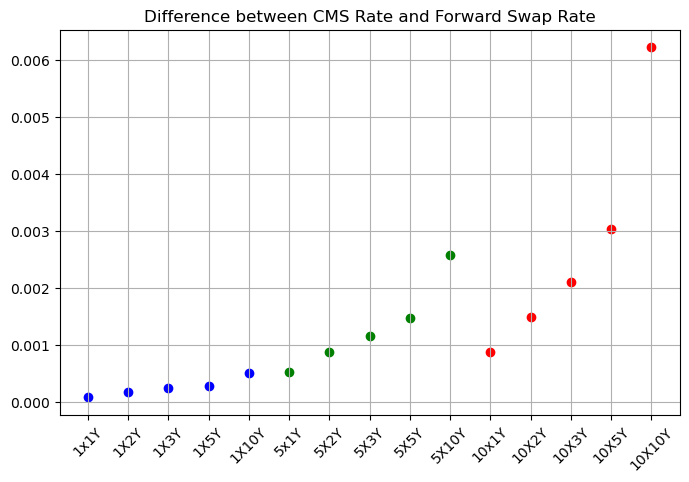

In [292]:
plt.figure(figsize = (8, 5))
plt.scatter(['1x1Y', '1X2Y', '1X3Y', '1X5Y', '1X10Y'], convexity_correction.loc[1,:], c = 'b')
plt.scatter(['5x1Y', '5X2Y', '5X3Y', '5X5Y', '5X10Y'], convexity_correction.loc[5,:], c = 'g')
plt.scatter(['10x1Y', '10X2Y', '10X3Y', '10X5Y', '10X10Y'], convexity_correction.loc[10,:], c = 'r')
plt.grid()
plt.xticks(rotation = 45)
plt.title('Difference between CMS Rate and Forward Swap Rate')